In [1]:
from platform import python_version

print(python_version())

3.9.5


Сначала соберём проект

In [2]:
!mkdir -p build && cd build && cmake .. && make

-- Configuring done
-- Generating done
-- Build files have been written to: /home/galqiwi/current_tasks/mpi-integration/build
Consolidate compiler generated dependencies of target main
[100%] Built target main


Запустим файл для того, чтобы посмотреть на формат вывода

In [3]:
!mpirun -np 4 ./build/main 10000

n = 10000
p = 4
I[0] = 0.979915
I[1] = 0.874676
I[2] = 0.719414
I[3] = 0.567788
I = 3.14179
Time = 0.000214308s


Напишем код, обрабатывающий этот вывод для построения графиков.

Для начала научимся запускать нашу программу из питона

In [4]:
import subprocess
from dataclasses import dataclass

In [5]:
EXECUTABLE_PATH = './build/main'

In [6]:
@dataclass(frozen=False)
class Run:
    n: int
    p: int
    integral: float
    time: float

In [7]:
def run_benchmark(n: int = 10 ** 4, p: int = 4):
    process = subprocess.run(f'mpirun -np {p} {EXECUTABLE_PATH} {n}', capture_output=True, shell=True)
    raw_output = process.stdout.decode().split('\n')

    class FormatError(Exception):
        pass

    run = Run(None, None, None, None)
    for line in raw_output:
        if line.startswith('n = '):
            run.n = int(line.removeprefix('n = '))
        if line.startswith('p = '):
            run.p = int(line.removeprefix('p = '))
        if line.startswith('I = '):
            run.integral = float(line.removeprefix('I = '))
        if line.startswith('Time = ') and line.endswith('s'):
            run.time = float(line.removeprefix('Time = ').removesuffix('s'))

    if None in (run.p, run.n, run.time, run.integral):
        raise FormatError(f'wrong command output {raw_output}')
    
    assert run.n == n and run.p == p, f'benchmark {run} is running with wrong numbers, expected ({n=}, {p=})'
    
    return run

In [8]:
run_benchmark(n = 10 ** 8, p = 8)

Run(n=100000000, p=8, integral=3.14159, time=0.244627)

Получилось простое API, с помощью которого можно набирать статистику. Теперь напишем код для сбора этой статистики и построения графика.

In [9]:
import numpy as np
import scipy.stats as sps
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import itertools

sns.set(palette='summer')

In [10]:
class Benchmarks:
    benchmarks_data = pd.DataFrame()

    def add_benchmark(self, n: int, p: int):
        run = run_benchmark(n, p)
        self.benchmarks_data = self.benchmarks_data.append({
            'n': np.int32(run.n),
            'p': np.int32(run.p),
            'integral': np.float32(run.integral),
            'time': np.float32(run.time)
        }, ignore_index=True)
        self.benchmarks_data = self.benchmarks_data.convert_dtypes()
    
    @property
    def mean_time(self):
        return self.benchmarks_data.groupby(['n', 'p']).mean().reset_index(level=0).reset_index(level=0)[['n', 'p', 'time']].convert_dtypes()
    
    @property
    def min_time(self):
        return self.mean_time[benchmarks.mean_time.p == 1][['n', 'time']].convert_dtypes()
    
    @property
    def speedup_data(self):
        out = self.mean_time.merge(self.min_time, left_on='n', right_on='n', suffixes=('', '_min')).convert_dtypes()
        out['speedup'] = out.time / out.time_min
        return out

In [11]:
# работает долго, это нормально
benchmarks = Benchmarks()

for n, p, measurement_id in itertools.product([10 ** 3, 10 ** 6, 10 ** 8], range(1, 9), range(16)):
    benchmarks.add_benchmark(n, p)

У нас получилось набрать статистику

In [12]:
benchmarks.speedup_data.head()

,n,p,time,time_min,speedup
0,1000,1,0.000045,0.000045,1.0
1,1000,2,0.000056,0.000045,1.238967
2,1000,3,0.000083,0.000045,1.824529
3,1000,4,0.000105,0.000045,2.312399
4,1000,5,0.000084,0.000045,1.845823


Теперь построим график и увидем, что при малых $N$ ($10^4$) при увеличении количества исполнителей, время только увеличивается, а при больших ($10^6-10^8$) значениях наблюдается эффект, который заключается в том, что, чем больше $N$, тем лучше распараллеливается наш алгоритм.

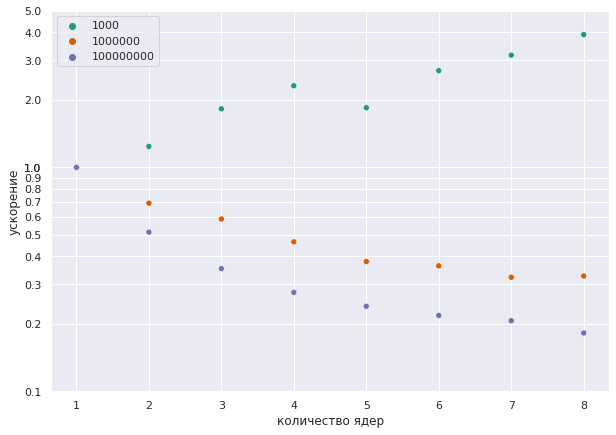

In [17]:
plt.figure(figsize=(10, 7))
ax = plt.gca()
sns.scatterplot(data = benchmarks.speedup_data,
                x='p', y='speedup',
                hue=pd.Categorical(benchmarks.speedup_data.n),
                palette='Dark2', ax=ax)

ax.set_yscale('log')
ax.set_xlabel('количество ядер')
ax.set_ylabel('ускорение')

y_ticks = list(np.linspace(start=0.1, stop=1.0, num=10)) + \
          list(np.linspace(start=1, stop=5, num=5))

plt.yticks(y_ticks, [f'{y:.1f}' for y in y_ticks])
plt.show()